In [9]:
from pathlib import Path
from utils.util import *
import plotly.express as px
output_dir = "data_analysis"
Path(output_dir).mkdir(parents=True, exist_ok=True)
real_data_1000_genome = load_real_data(hapt_genotypes_path=f"../{REAL_10K_SNP_1000G_PATH}",
                                       extra_data_path=f"../{REAL_EXTRA_DATA_PATH}")
# real_data_1000_genome = real_data_1000_genome[
#     ~real_data_1000_genome['Superpopulation code'].str.contains(',', na=False)]

In [10]:
real_data_1000_genome

,0,1,2,3,4,5,6,7,8,9,...,10001,Sample name,Sex,Biosample ID,Population code,Population name,Superpopulation code,Superpopulation name,Population elastic ID,Data collections
1,,,,,,,,,,,,,,,,,,,,,
HG00096,Real,HG00096,0,0,0,0,1,0,1,0,...,0,HG00096,male,SAME123268,GBR,British,EUR,European Ancestry,GBR,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
HG00096,Real,HG00096,0,0,0,0,1,0,1,0,...,0,HG00096,male,SAME123268,GBR,British,EUR,European Ancestry,GBR,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
HG00097,Real,HG00097,0,0,0,0,1,0,1,0,...,0,HG00097,female,SAME123267,GBR,British,EUR,European Ancestry,GBR,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
HG00097,Real,HG00097,1,0,0,0,0,1,1,0,...,0,HG00097,female,SAME123267,GBR,British,EUR,European Ancestry,GBR,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
HG00099,Real,HG00099,0,0,0,0,1,0,1,0,...,0,HG00099,female,SAME123271,GBR,British,EUR,European Ancestry,GBR,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA21142,Real,NA21142,0,0,0,0,0,0,1,0,...,0,NA21142,female,SAME123344,GIH,Gujarati,SAS,South Asian Ancestry,GIH,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
NA21143,Real,NA21143,0,0,1,0,0,0,1,0,...,0,NA21143,female,SAME123359,GIH,Gujarati,SAS,South Asian Ancestry,GIH,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
NA21143,Real,NA21143,1,0,0,0,0,1,1,0,...,0,NA21143,female,SAME123359,GIH,Gujarati,SAS,South Asian Ancestry,GIH,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."


In [11]:
import pandas as pd

# Assuming you have a DataFrame named 'df' containing the sample data
# Count the number of unique Population codes within each Superpopulation code
population_counts = real_data_1000_genome.groupby('Superpopulation code')['Population code'].nunique().reset_index()
population_counts = population_counts.rename(columns={'Superpopulation code': 'Superpopulation', 'Population code': 'Population Count'})

# Concatenate all Population codes within each Superpopulation code, separated by comma
population_list = real_data_1000_genome.groupby('Superpopulation code')['Population code'].unique().reset_index()
population_counts['Population Codes'] = population_list['Population code'].apply(lambda x: ', '.join(x))

# Count the number of unique Superpopulation codes
superpopulation_count = real_data_1000_genome['Superpopulation code'].nunique()

# Create the table
table = pd.DataFrame({
    'Superpopulation': population_counts['Superpopulation'],
    'Population Count': population_counts['Population Count'],
    'Population Codes': population_counts['Population Codes']
})

counts = pd.DataFrame(real_data_1000_genome.groupby('Superpopulation code').count()[0])
print("pop counts by national: ",pd.DataFrame(real_data_1000_genome.groupby('Population code').count()[0]))
counts["Superpopulation"] = counts.index
table = pd.merge(table, counts, on='Superpopulation', how='left')

mean_by_pop = pd.DataFrame(pd.DataFrame(real_data_1000_genome.groupby(['Superpopulation code', 'Population code']).count()[0]).groupby('Superpopulation code').mean()[0]).round(2)
mean_by_pop["Superpopulation"] = mean_by_pop.index
table = pd.merge(table, mean_by_pop, on='Superpopulation', how='left')

table = table.rename(columns={'Superpopulation': '$\\bf{Continental}$ $\\bf{Populations}$', 'Population Count': '$\\bf{National}$ $\\bf{Count}$', 'Population Codes': '$\\bf{National}$ $\\bf{Populations}$', "0_x": '$\\bf{Continental}$ #$\\bf{Haplotypes}$', "0_y": '$\\bf{National}$ $\\bf{Mean}$ #$\\bf{Haplotypes}$'})

# Display the table
print(table)


pop counts by national:                     0
Population code     
ACB              192
ASW              122
BEB              172
CDX              186
CEU              198
CHB              206
CHS              210
CLM              188
ESN              198
FIN              198
GBR              182
GIH              206
GWD              226
IBS              212
IBS,MSL            2
ITU              204
JPT              208
KHV              198
LWK              198
MSL              170
MXL              128
PEL              170
PJL              192
PUR              208
STU              204
TSI              214
YRI              216
  $\bf{Continental}$ $\bf{Populations}$  $\bf{National}$ $\bf{Count}$   
0                                   AFR                             7  \
1                                   AMR                             4   
2                                   EAS                             5   
3                                   EUR                             5   
4

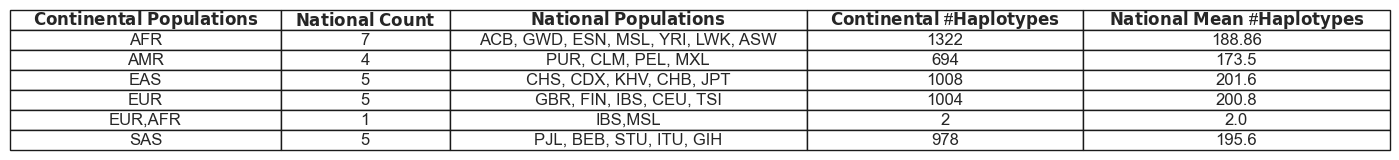

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'table' containing the data
# Create a table visualization
fig, ax = plt.subplots(figsize=(12, 1.7))
ax.axis('off')  # Hide axis
table_plot = ax.table(cellText=table.values, colLabels=table.columns, cellLoc='center', loc='center')

# Set table properties
table_plot.auto_set_font_size(False)
table_plot.set_fontsize(12)
table_plot.scale(1.2, 1.2)

# Adjust the width of the 'Population Codes' column
column_widths = [0.15, 0.3, 0.2, 0.2, 0.2]  # Adjust the values as needed
for i, width in enumerate(column_widths):
    table_plot.auto_set_column_width([i])
    table_plot.get_celld()[(0, i)].set_width(width)



# Save the table as a JPG image
plt.savefig(os.path.join(output_dir, 'table.jpg'), bbox_inches='tight', pad_inches=0.5, dpi=300)


In [4]:
sns.set(style="whitegrid", rc={"figure.figsize": (20, 10)})


def plot_number_of_samples(target_column_name: str, output_path: str):
    ax = sns.countplot(x=target_column_name, data=real_data_1000_genome)
    plt.xlabel(target_column_name)
    plt.ylabel("Number of Samples")
    plt.title("Number of Samples by " + target_column_name)

    # Add count values to the plot
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plt.savefig(output_path)
    plt.show()

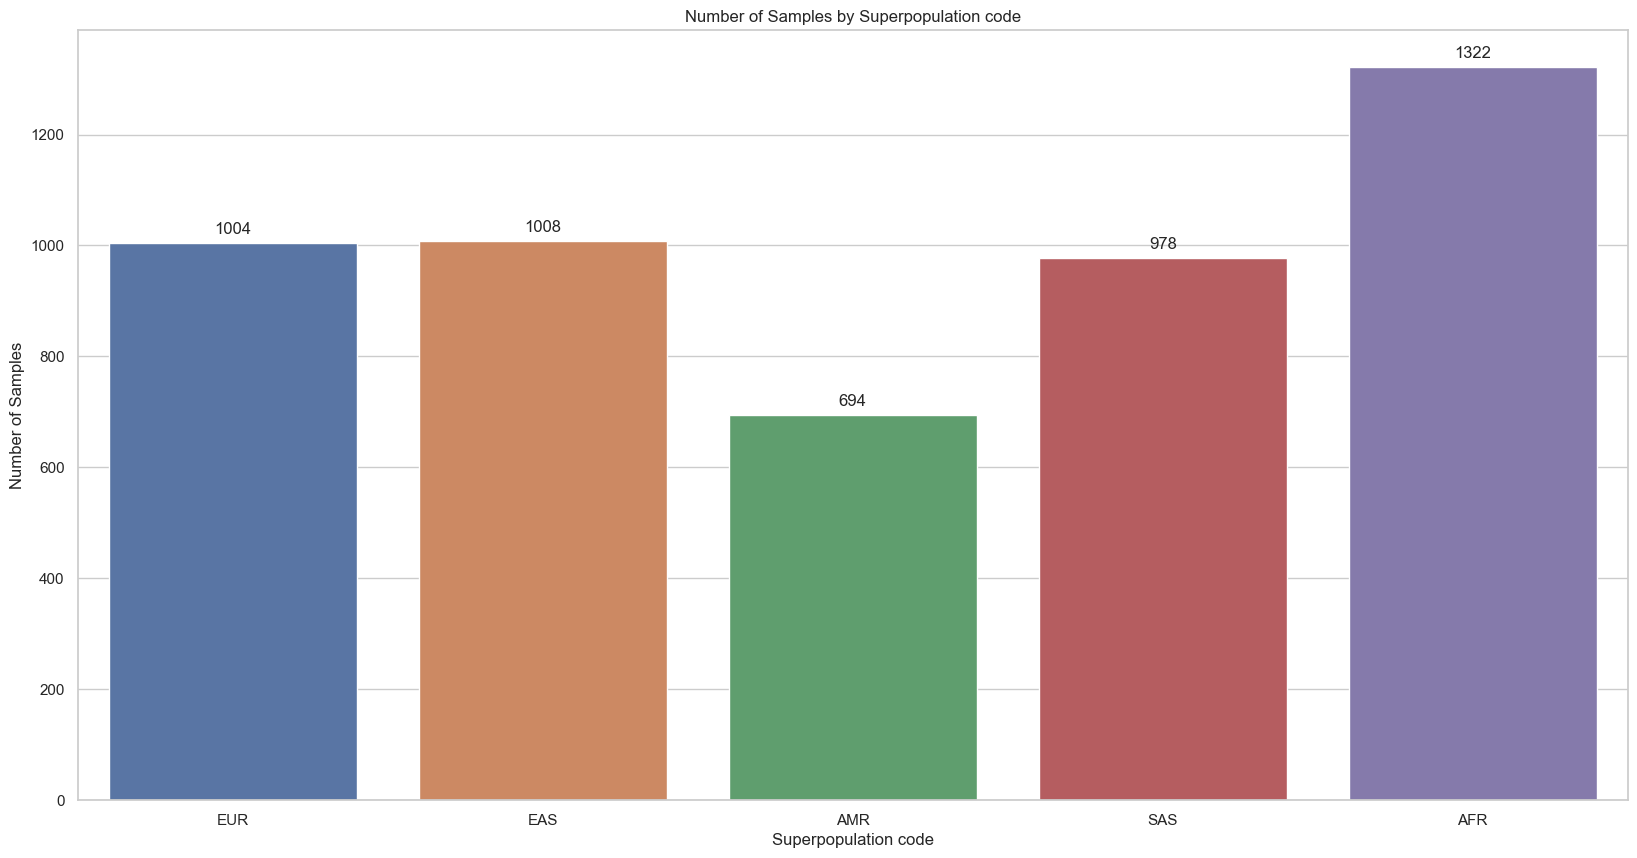

In [5]:
plot_number_of_samples("Superpopulation code", output_path=os.path.join(output_dir, "super_population_distribution.jpg"))

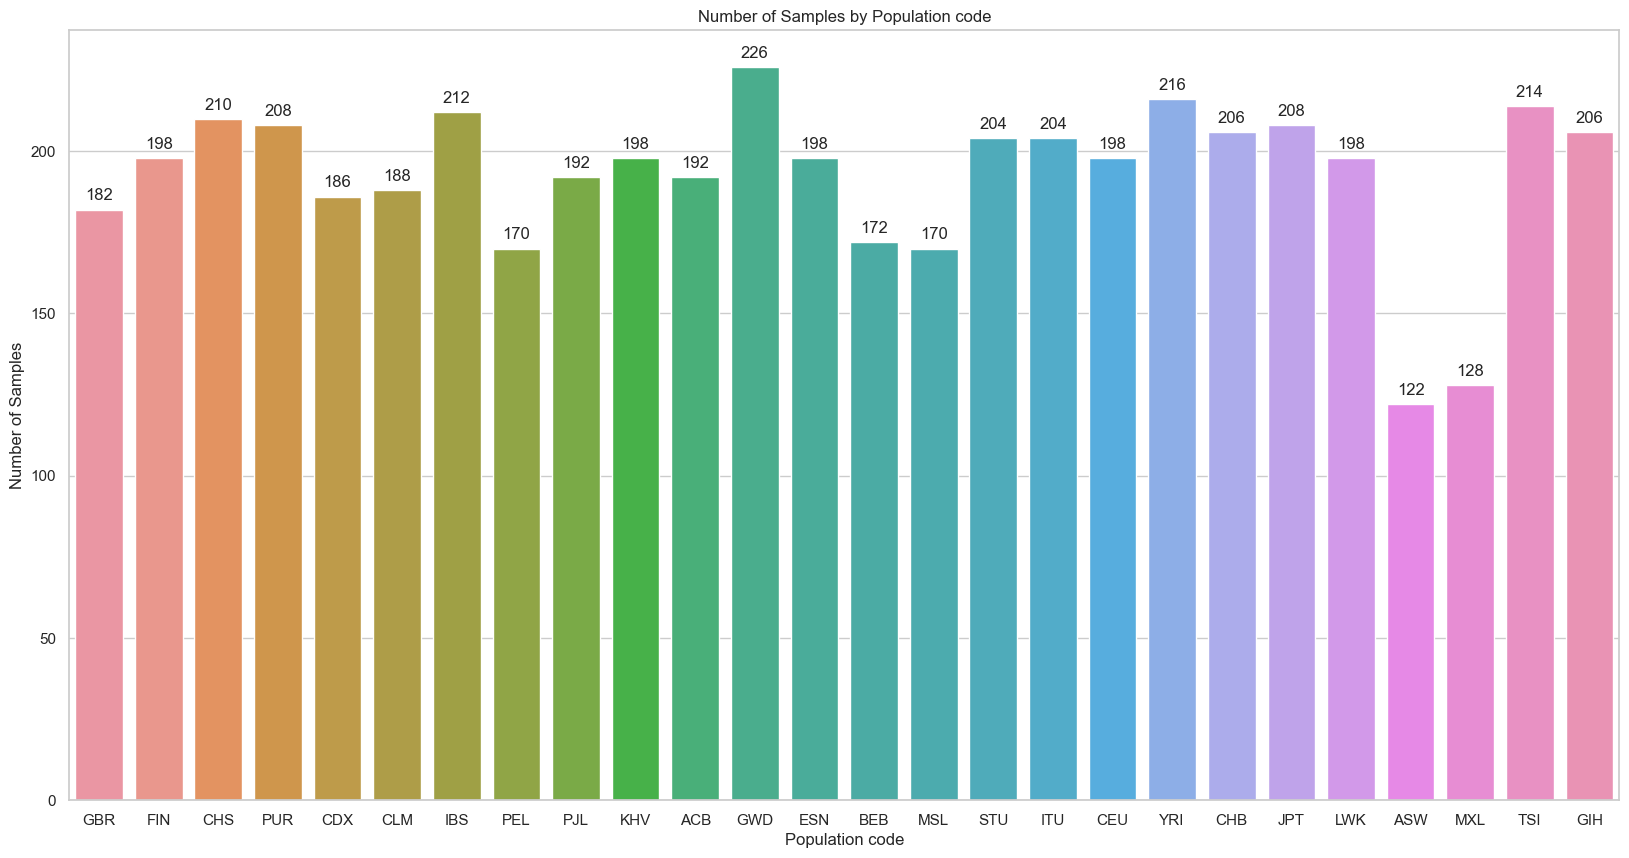

In [6]:
plot_number_of_samples("Population code", output_path=os.path.join(output_dir, "sub_population_distribution.jpg"))

In [7]:
genotypes_ids = get_relevant_columns(input_df=real_data_1000_genome, input_columns=[])
# genotypes_ids.pop(0)
# genotypes_ids.pop(0)
print(f"Number of SNPs: {len(genotypes_ids)}")

Number of SNPs: 10000


In [ ]:
def print_frequency(current_df, target_column, title):
    rows = []
    for pop in current_df[target_column].unique():
        tmp_df = current_df[current_df[target_column] == pop]
        uniques, counts = np.unique(tmp_df[genotypes_ids], return_counts=True)
        tmp_percentages = dict(zip(uniques, 100 * counts / (len(tmp_df[genotypes_ids]) * len(genotypes_ids))))
        # tmp_percentages = {key: f"{str(round(values, 2))}%" for key, values in tmp_percentages.items()}
        tmp_percentages = {key: round(values, 2) for key, values in tmp_percentages.items()}
        tmp_percentages["pop"] = pop
        rows.append(tmp_percentages)
    # print("\033[91m \033[1m ", title, "\033[0m")
    # print(pd.DataFrame(rows).plot())
    df = pd.DataFrame(rows)
    df.set_index('pop', inplace=True)
    df.plot.bar()


Allele Frequency

In [ ]:
print_frequency(current_df=real_data_1000_genome, target_column=0, title="allele frequencies all")

In [ ]:
print_frequency(current_df=real_data_1000_genome, target_column="Superpopulation code",
                title="allele frequencies by Superpopulation code")

In [ ]:
print_frequency(current_df=real_data_1000_genome, target_column="Population code",
                title="allele frequencies by Population code")

PCA

In [ ]:
n_components = 2
pca = PCA(n_components=n_components)
components = pca.fit_transform(real_data_1000_genome[genotypes_ids])

In [ ]:
fig = px.scatter(components, x=0, y=1, color=real_data_1000_genome["Superpopulation code"],
                 title="PCA By Super Population")
fig.show()

In [ ]:
fig = px.scatter(components, x=0, y=1, color=real_data_1000_genome["Population code"],
                 title="PCA By Population")
fig.show()

In [ ]:
n_components = 2
pca = PCA(n_components=n_components)
real_data_1000_genome_afr = real_data_1000_genome[real_data_1000_genome["Population code"].isin(["ACB", "GWD", "ESN", "MSL", "YRI", "LWK", "ASW"])]
components_by_afr = pca.fit_transform(real_data_1000_genome_afr[genotypes_ids])

In [ ]:
components_by_afr

In [ ]:
c = pd.concat([pd.DataFrame(components_by_afr),real_data_1000_genome_afr["Population code"].reset_index()], axis=1)
print(c)

In [ ]:
import os
import numpy as np
import plotly.graph_objects as go

# Assume you already have these defined
n_components = 3
pca = PCA(n_components=n_components)
real_data_1000_genome_afr = real_data_1000_genome[real_data_1000_genome["Population code"].isin(["ACB", "GWD", "ESN", "MSL", "YRI", "LWK", "ASW"])]
components_by_afr = pca.fit_transform(real_data_1000_genome_afr[genotypes_ids])
# Calculate the centroid of the data
centroid = np.mean(components_by_afr, axis=0)

# Calculate the distance of each data point from the centroid
distances_from_centroid = np.linalg.norm(components_by_afr - centroid, axis=1)

# Define the mapping between categorical values and colors
color_mapping = {
    'ACB': 'green',
    'GWD': 'red',
    'ESN': 'gray',
    'MSL': 'yellow',
    'YRI': 'blue',
    'LWK': 'black',
    'ASW': 'pink',
}

# Map the categorical values to corresponding colors for the scatter plot
colors = real_data_1000_genome_afr["Population code"].map(color_mapping)

# Calculate marker size based on distances (dispersion)
marker_sizes = (distances_from_centroid / max(distances_from_centroid)) * 20 + 20  # Adjust scaling and offset as needed

# Create a 3D scatter plot using Plotly
fig = go.Figure()

for population in real_data_1000_genome_afr['Population code'].unique():
    mask = (real_data_1000_genome_afr['Population code'] == population)
    fig.add_trace(go.Scatter3d(
        x=components_by_afr[mask, 0],
        y=components_by_afr[mask, 1],
        z=components_by_afr[mask, 2],
        mode='markers',
        marker=dict(
            size=marker_sizes[mask],  # Use the calculated marker sizes here
            color=colors[mask],  # Use the colors variable here
            opacity=0.4
        ),
        name=population,  # Specify the name for the legend
    ))


# Customize the appearance
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3',
        xaxis=dict(backgroundcolor='white',title_font=dict(size=30, color='black'),gridwidth=5),  # Set the x-axis grid background to white
        yaxis=dict(backgroundcolor='white',title_font=dict(size=30, color='black'),gridwidth=5),  # Set the y-axis grid background to white
        zaxis=dict(backgroundcolor='white',title_font=dict(size=30, color='black'),gridwidth=5),  # Set the z-axis grid background to white
        bgcolor='white', # Set the plot background color to transparent
        camera=dict(
            eye=dict(x=1.1, y=1, z=1),  # Adjust the camera eye position to zoom in
        ),
    ),
    width=1200,
    height=800,
    margin=dict(l=0, r=0, t=0, b=0),  # Remove margins around the plot area
    legend=dict(
        bgcolor='black',
        bordercolor='black',
        borderwidth=10,
        itemsizing='trace',
        itemclick='toggle',
        font=dict(size=34)

    ),
    xaxis_title_font=dict(size=50),
    yaxis_title_font=dict(size=50),
    autosize=False,  # Disable autosize to match the specified width and height

)

# Save the figure as an image
output_path = os.path.join(output_dir, "AFR_PCA_3D.jpg")
fig.write_image(output_path, format='jpeg', engine='kaleido')

# Show the figure
fig.show()
